# EDA для Disease Risk Prediction Dataset

## Цель анализа
Провести разведочный анализ медицинского датасета для оценки:
- Качества данных и пригодности для дальнейшего анализа
- Выявления необходимых трансформаций в ETL-пайплайне
- Понимания распределений и взаимосвязей признаков

## Метрики 
Оценить качество данных необходимо опираясь на слующие метрики:
- Completeness (полнота данных)
- Uniqueness (уникальность) 
- Структурная целостность
- Семантическая валидность

## Используемые инструменты
- pandas для анализа
- numpy для вычислений
- Встроенные визуализации pandas

## 0. Импорт необходимых библиотек и настройка отображения

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# настройки отображения
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

## 1. Первичная оценка DataSet: размеры и информация о данных - структурный анализ

In [7]:
df = pd.read_csv('data/raw/disease_risk_dataset.csv')

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПервые 5 строк:")
display(df.head())
print("\nИнформация о данных:")
df.info()

Размер датасета: 4000 строк, 15 столбцов

Первые 5 строк:


,Patient_ID,Age,Gender,BMI,Smoking_Status,Alcohol_Consumption,Physical_Activity_Level,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Level,Glucose_Level,Family_History,Genetic_Risk_Score,Previous_Diagnosis,Disease_Risk
0,P100000,69,Female,27.8,Never,NaN,Low,92,117,297,156,Yes,0.52,NaN,No
1,P100001,32,Female,32.0,Never,Moderate,Moderate,149,77,279,163,Yes,0.50,NaN,Yes
2,P100002,89,Male,24.2,Former,High,High,124,82,189,139,Yes,0.37,Diagnosed,No
3,P100003,78,Male,23.8,Never,NaN,Moderate,118,81,159,169,No,0.55,NaN,No
4,P100004,38,Male,29.8,Never,Moderate,Moderate,164,63,213,97,Yes,0.59,Pre-disease,No



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient_ID                4000 non-null   object 
 1   Age                       4000 non-null   int64  
 2   Gender                    4000 non-null   object 
 3   BMI                       4000 non-null   float64
 4   Smoking_Status            4000 non-null   object 
 5   Alcohol_Consumption       2361 non-null   object 
 6   Physical_Activity_Level   4000 non-null   object 
 7   Blood_Pressure_Systolic   4000 non-null   int64  
 8   Blood_Pressure_Diastolic  4000 non-null   int64  
 9   Cholesterol_Level         4000 non-null   int64  
 10  Glucose_Level             4000 non-null   int64  
 11  Family_History            4000 non-null   object 
 12  Genetic_Risk_Score        4000 non-null   float64
 13  Previous_Diagnosis        1973 non-null  

## 2. Уникальность идентификаторов

In [8]:
unique_ids = df['Patient_ID'].nunique()
total_rows = len(df)
duplicate_ids = df['Patient_ID'].duplicated().sum()
duplicate_rows = df.duplicated().sum()

print(f"Уникальных Patient_ID: {unique_ids} из {total_rows}")
print(f"Дубликатов Patient_ID: {duplicate_ids}")
print(f"Полностью дублирующихся строк: {duplicate_rows}")

Уникальных Patient_ID: 4000 из 4000
Дубликатов Patient_ID: 0
Полностью дублирующихся строк: 0


## 3. Логическая целостность данных

### 3.1. Числовые значения

In [9]:
# проверка возрастного диапазона
min_age = df['Age'].min()
max_age = df['Age'].max()
abnormal_age = ((df['Age'] < 0) | (df['Age'] > 120)).sum()

print(f"Возраст: {min_age}-{max_age} лет")
print(f"Аномальные значения (<0 или >120): {abnormal_age}")

# проверка соотношения давлений
pressure_issues = (df['Blood_Pressure_Systolic'] <= df['Blood_Pressure_Diastolic']).sum()
print(f"Некорректное соотношение давлений: {pressure_issues} записей")

# проверка неотрицательных значений
numeric_columns = ['BMI', 'Cholesterol_Level', 'Glucose_Level', 'Genetic_Risk_Score']
print("Проверка неотрицательных значений")

for column in numeric_columns:
    negative_values = (df[column] < 0).sum()
    print(f"  Для <{column}> отрицательных значений: {negative_values}")

Возраст: 18-89 лет
Аномальные значения (<0 или >120): 0
Некорректное соотношение давлений: 340 записей
Проверка неотрицательных значений
  Для <BMI> отрицательных значений: 0
  Для <Cholesterol_Level> отрицательных значений: 0
  Для <Glucose_Level> отрицательных значений: 0
  Для <Genetic_Risk_Score> отрицательных значений: 0


### 3.2. Категориальные значения

In [10]:
categorical_cols = [
    "Gender", "Smoking_Status", "Alcohol_Consumption", 
    "Physical_Activity_Level", "Family_History", 
    "Previous_Diagnosis", "Disease_Risk"
]

for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")
    print(f"Пропусков: {df[col].isnull().sum()}\n")

Gender: ['Female' 'Male' 'Other']
Пропусков: 0

Smoking_Status: ['Never' 'Former' 'Current']
Пропусков: 0

Alcohol_Consumption: [nan 'Moderate' 'High']
Пропусков: 1639

Physical_Activity_Level: ['Low' 'Moderate' 'High']
Пропусков: 0

Family_History: ['Yes' 'No']
Пропусков: 0

Previous_Diagnosis: [nan 'Diagnosed' 'Pre-disease']
Пропусков: 2027

Disease_Risk: ['No' 'Yes']
Пропусков: 0



## 4. Анализ полноты данных

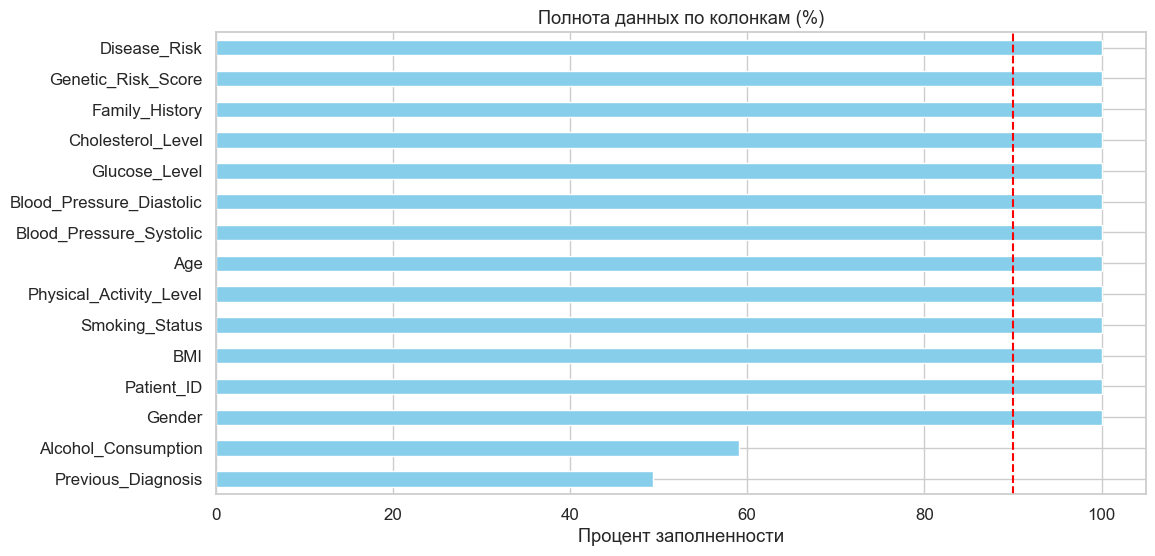

In [11]:
completeness = (1 - df.isnull().sum() / len(df)) * 100

plt.figure(figsize=(12, 6))
completeness.sort_values().plot(kind='barh', color='skyblue')
plt.axvline(x=90, color='red', linestyle='--', label='Порог 90%')
plt.title('Полнота данных по колонкам (%)')
plt.xlabel('Процент заполненности')
plt.show()

## 5. Анализ целевой переменной

Распределение целевой переменной Disease_Risk:
Disease_Risk
No     85.475
Yes    14.525
Name: proportion, dtype: float64


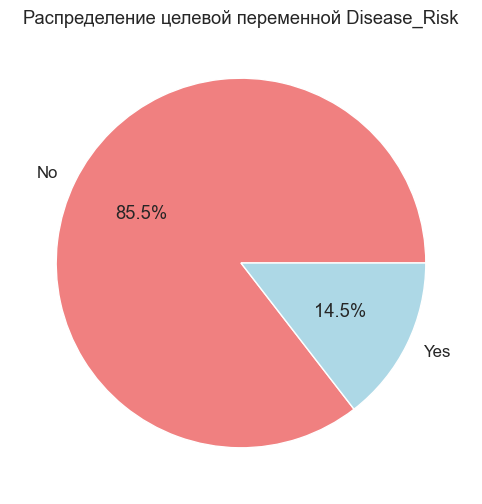

In [12]:
target_distribution = df['Disease_Risk'].value_counts(normalize=True) * 100
print("Распределение целевой переменной Disease_Risk:")
print(target_distribution)

plt.figure(figsize=(8, 6))
df['Disease_Risk'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Распределение целевой переменной Disease_Risk')
plt.ylabel('')
plt.show()

## 6. Статистический анализ числовых признаков

In [13]:
print("Описательная статистика числовых признаков:")
display(df.describe())

Описательная статистика числовых признаков:


,Age,BMI,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Level,Glucose_Level,Genetic_Risk_Score
count,4000.00000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,53.22350,27.008025,134.64150,89.529500,224.404500,133.946250,0.500140
std,20.63234,5.020856,25.92738,17.455996,43.255458,38.027857,0.099428
min,18.00000,6.700000,90.00000,60.000000,150.000000,70.000000,0.200000
25%,36.00000,23.600000,113.00000,74.000000,187.000000,100.000000,0.430000
50%,53.00000,27.000000,134.00000,89.000000,223.000000,134.000000,0.500000
75%,71.00000,30.400000,157.00000,105.000000,262.000000,167.000000,0.570000
max,89.00000,44.800000,179.00000,119.000000,299.000000,199.000000,0.930000


Гистограммы распределения числовых признаков:


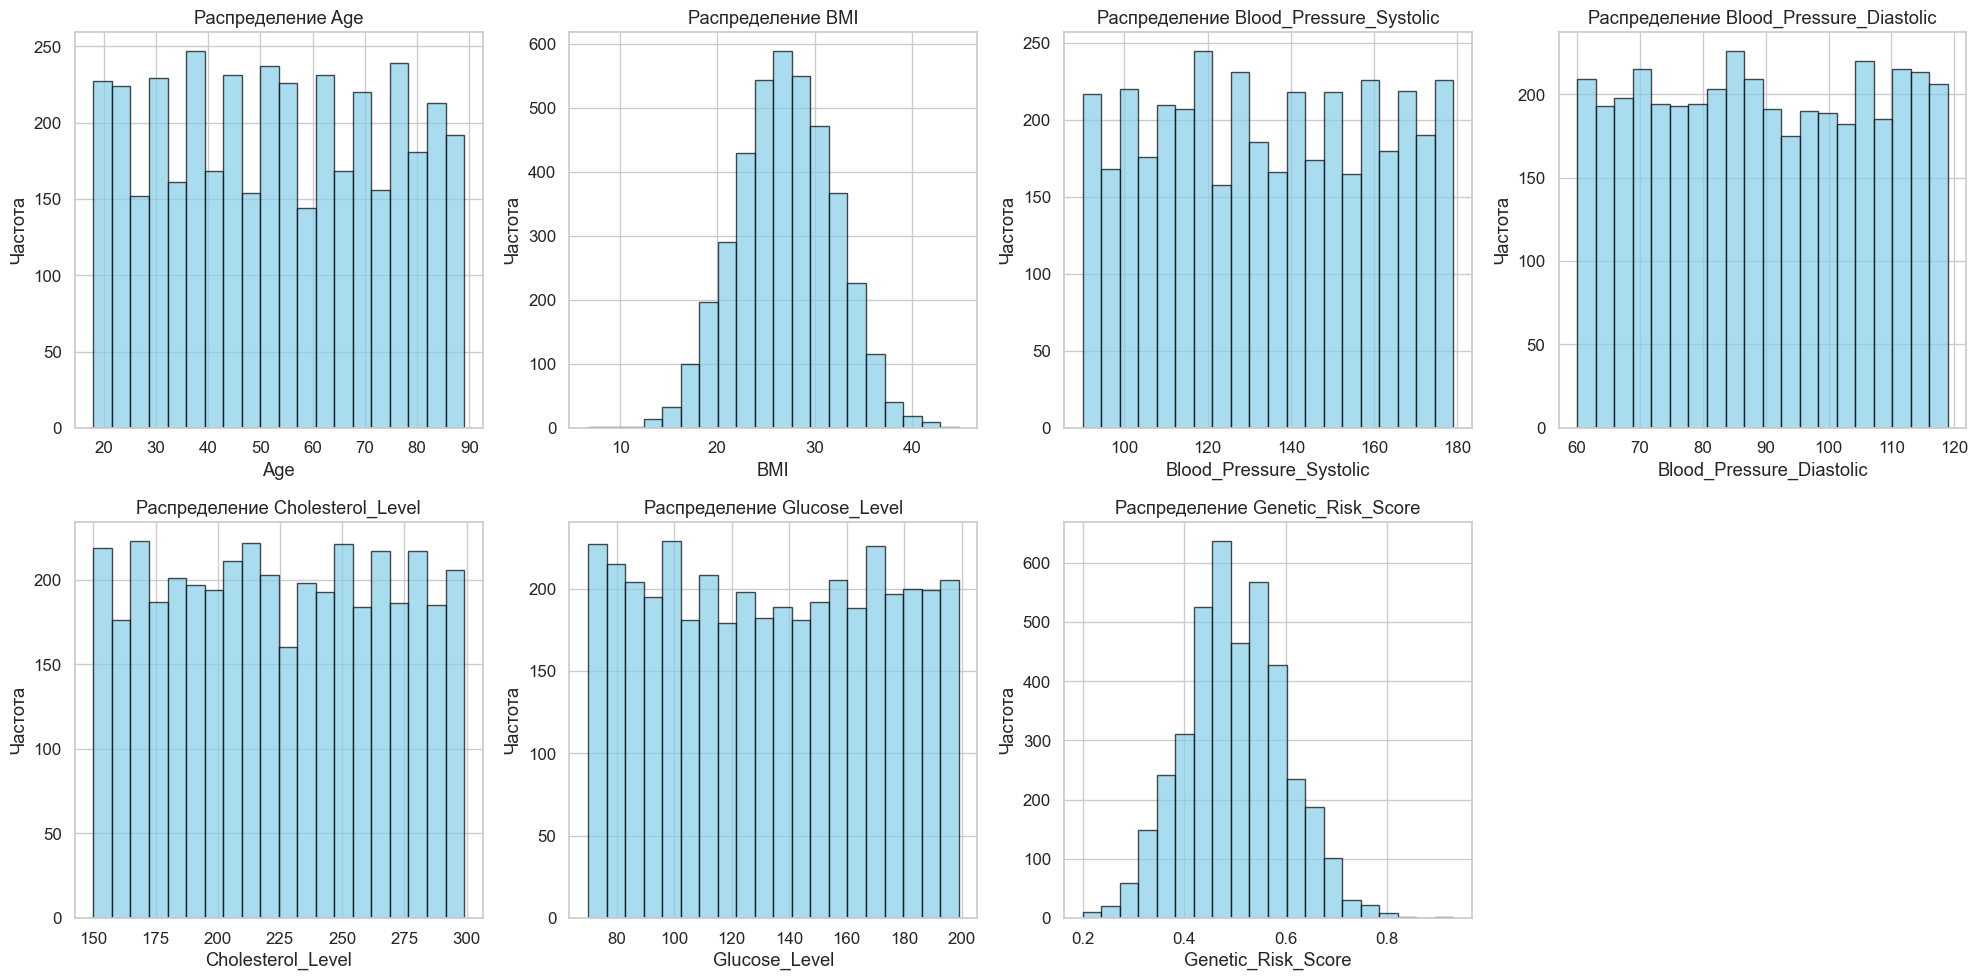

In [14]:
numeric_cols = ['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 
                'Cholesterol_Level', 'Glucose_Level', 'Genetic_Risk_Score']

print("Гистограммы распределения числовых признаков:")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    df[col].hist(ax=axes[i], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

## 7. Анализ распределений категориальных переменных

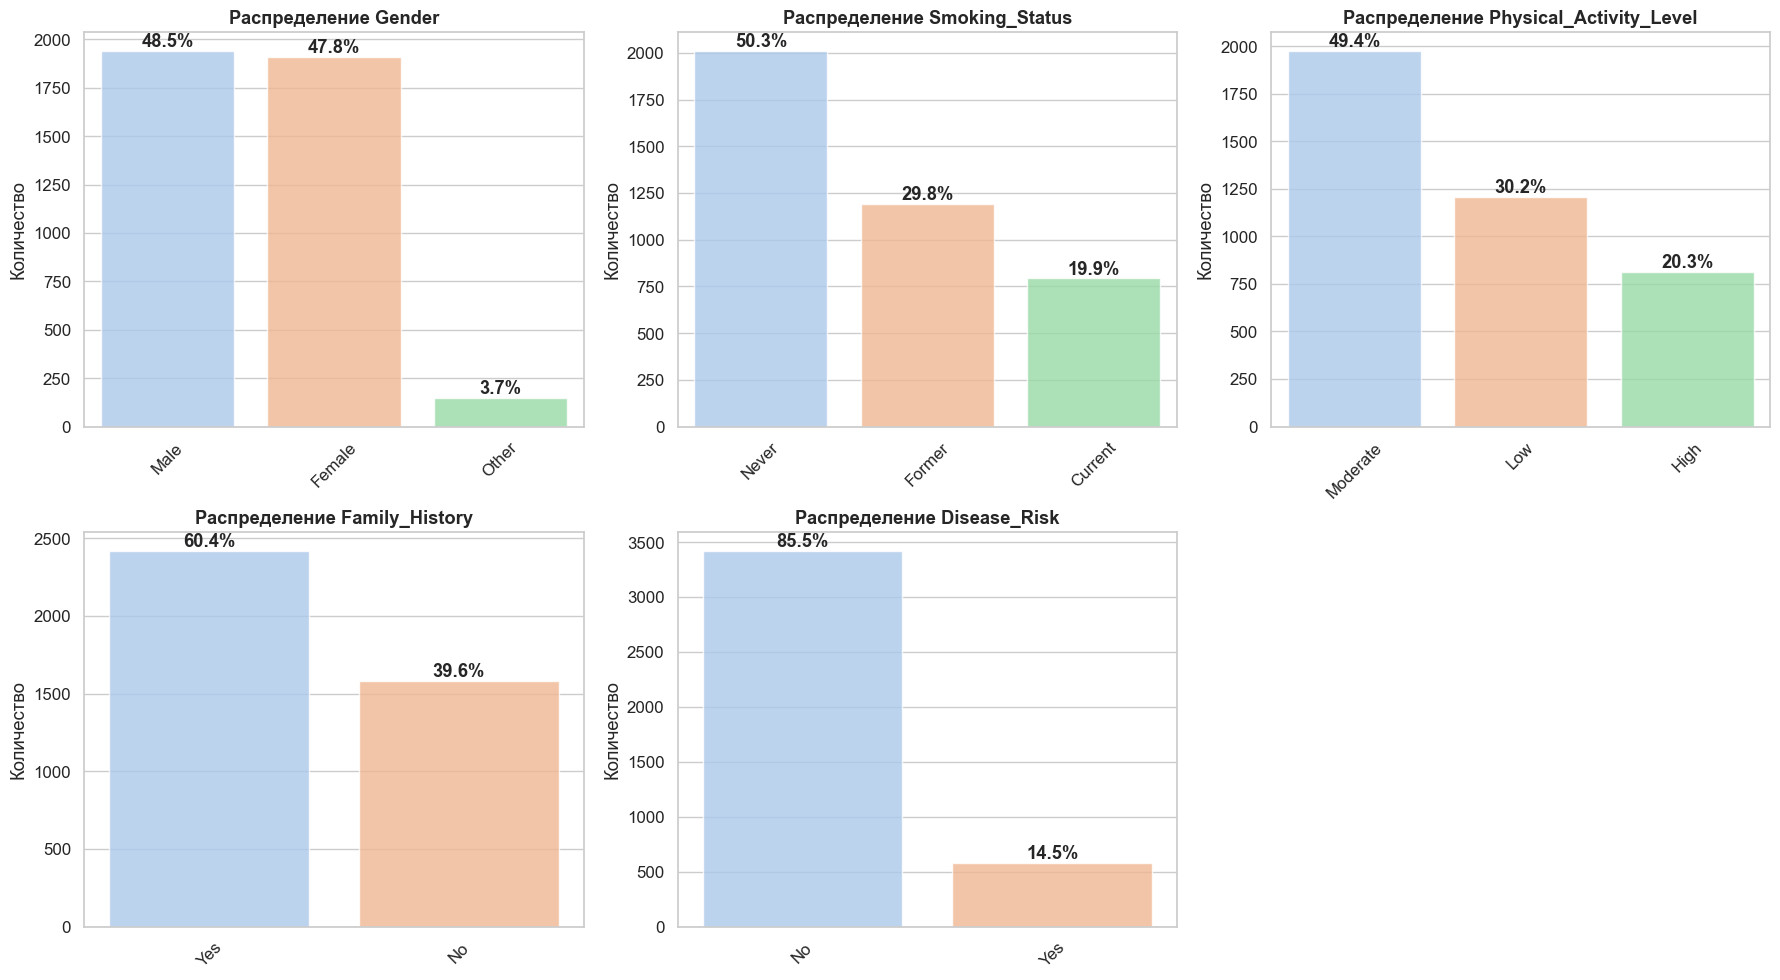

In [15]:
categorical_cols = ['Gender', 'Smoking_Status', 'Physical_Activity_Level', 
                    'Family_History', 'Disease_Risk']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        value_counts = df[col].value_counts()

        sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i], 
                   hue=value_counts.index, palette='pastel', legend=False, alpha=0.8)
        
        axes[i].set_title(f'Распределение {col}', fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Количество')

        # добавление %
        total_count = len(df[col].dropna())
        for j, count in enumerate(value_counts):
            percentage = (count / total_count) * 100
            axes[i].text(j, count, f'{percentage:.1f}%', 
                        ha='center', va='bottom', fontweight='bold')
        
        axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

## 8. Анализ выбросов 

Анализ выбросов для числовых признаков

Age:
  - Выбросов: 0 (0.0%)
  - Границы: [-16.5, 123.5]
  - Min/Max: [18.0, 89.0]

BMI:
  - Выбросов: 25 (0.6%)
  - Границы: [13.4, 40.6]
  - Min/Max: [6.7, 44.8]

Blood_Pressure_Systolic:
  - Выбросов: 0 (0.0%)
  - Границы: [47.0, 223.0]
  - Min/Max: [90.0, 179.0]

Blood_Pressure_Diastolic:
  - Выбросов: 0 (0.0%)
  - Границы: [27.5, 151.5]
  - Min/Max: [60.0, 119.0]

Cholesterol_Level:
  - Выбросов: 0 (0.0%)
  - Границы: [74.5, 374.5]
  - Min/Max: [150.0, 299.0]

Glucose_Level:
  - Выбросов: 0 (0.0%)
  - Границы: [-0.5, 267.5]
  - Min/Max: [70.0, 199.0]

Genetic_Risk_Score:
  - Выбросов: 23 (0.6%)
  - Границы: [0.2, 0.8]
  - Min/Max: [0.2, 0.9]

--------------------------------------------------
Сводная таблица выбросов:


,column,count,percentage
1,BMI,25,0.625
6,Genetic_Risk_Score,23,0.575
0,Age,0,0.000
2,Blood_Pressure_Systolic,0,0.000
3,Blood_Pressure_Diastolic,0,0.000
4,Cholesterol_Level,0,0.000
5,Glucose_Level,0,0.000


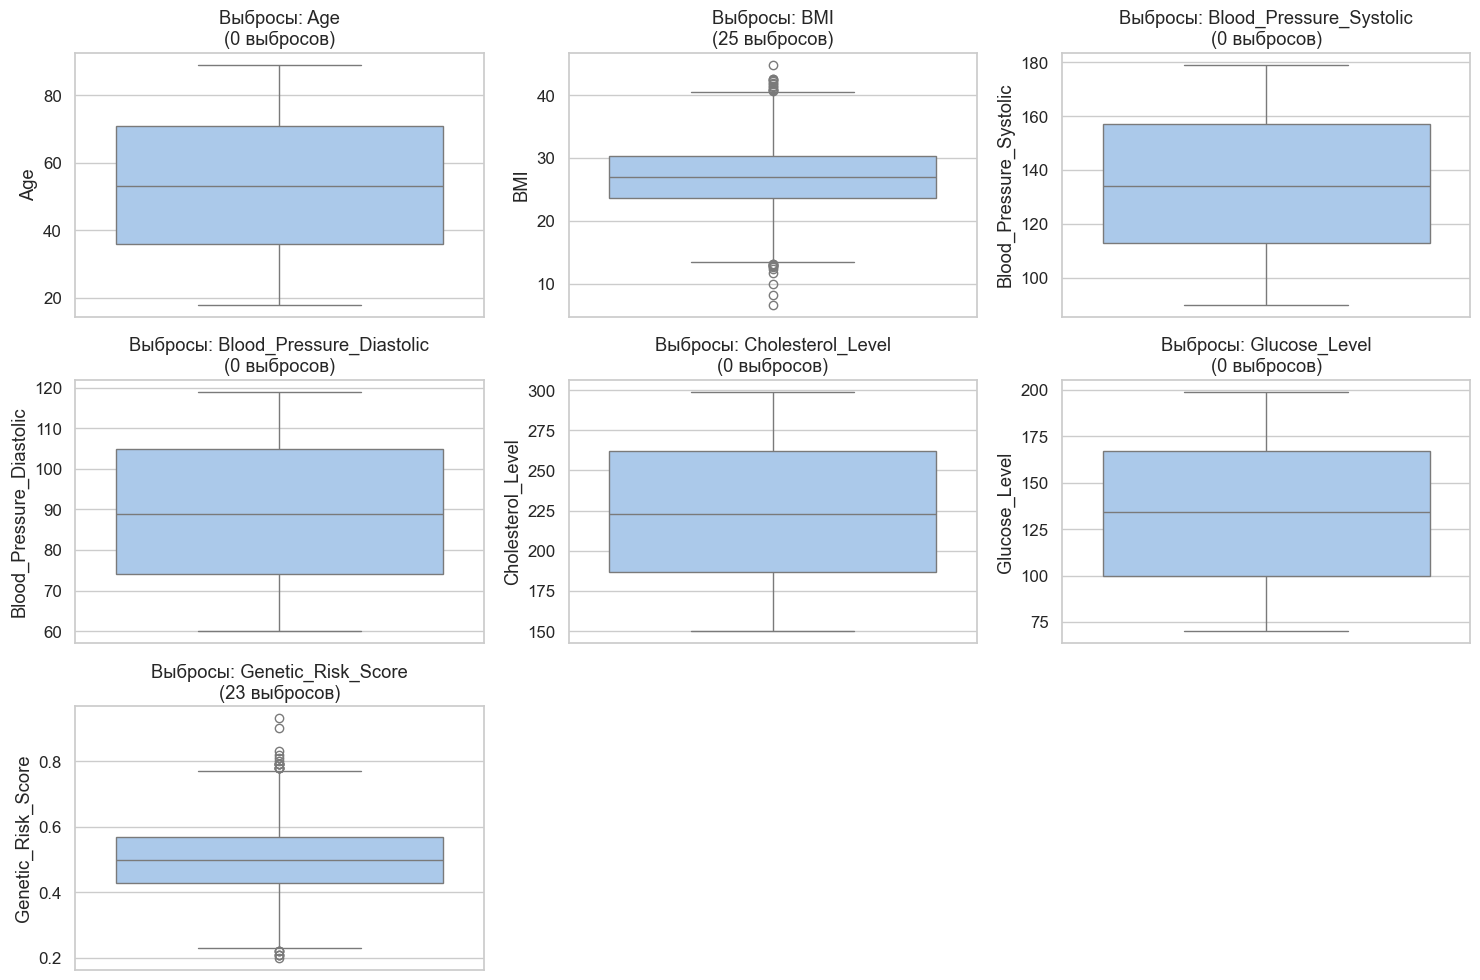

In [16]:
numeric_columns = ['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 
                   'Cholesterol_Level', 'Glucose_Level', 'Genetic_Risk_Score']

print("Анализ выбросов для числовых признаков")

# метод IQR для определения выбросов
outliers_summary = []
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    print(f"\n{column}:")
    print(f"  - Выбросов: {outlier_count} ({outlier_percentage:.1f}%)")
    print(f"  - Границы: [{lower_bound:.1f}, {upper_bound:.1f}]")
    print(f"  - Min/Max: [{df[column].min():.1f}, {df[column].max():.1f}]")
    
    outliers_summary.append({
        'column': column,
        'count': outlier_count,
        'percentage': outlier_percentage
    })

# сводная таблица выбросов
print("\n" + "-"*50)
print("Сводная таблица выбросов:")
outliers_df = pd.DataFrame(outliers_summary)
display(outliers_df.sort_values('percentage', ascending=False))

# визуализация выбросов
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Выбросы: {column}\n({outliers_summary[i-1]["count"]} выбросов)')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

### Выбросы в колонках BMI. Проверка выбросов

In [17]:
# Найти ВСЕ выбросы BMI (верхние и нижние)
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bmi_outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]
print(f"Найдено {len(bmi_outliers)} выбросов BMI")
print(f"Границы выбросов: [{lower_bound:.3f}, {upper_bound:.3f}]")

# Посмотреть их подробно
print("Выбросы BMI:")
display(bmi_outliers[['Age', 'Gender', 'BMI', 'Genetic_Risk_Score', 
                     'Blood_Pressure_Systolic', 'Cholesterol_Level', 
                     'Glucose_Level', 'Disease_Risk']])

Найдено 25 выбросов BMI
Границы выбросов: [13.400, 40.600]
Выбросы BMI:


,Age,Gender,BMI,Genetic_Risk_Score,Blood_Pressure_Systolic,Cholesterol_Level,Glucose_Level,Disease_Risk
25,79,Female,11.7,0.28,134,242,181,No
187,76,Male,40.8,0.60,90,257,180,No
307,77,Male,41.3,0.70,103,287,125,No
875,46,Female,41.9,0.46,122,152,149,Yes
894,89,Female,41.8,0.44,111,216,141,No
940,24,Male,13.1,0.36,145,190,98,No
1186,51,Male,42.5,0.52,94,192,91,No
1235,69,Female,12.9,0.57,98,197,147,No
1334,81,Other,44.8,0.39,112,257,73,No
1539,51,Male,12.9,0.53,104,201,172,No


### Выбросы в колонках Genetic_Risk_Score - 23 выброса. Проверка выбросов

In [18]:
# Найти ВСЕ выбросы Genetic_Risk_Score (верхние и нижние)
Q1 = df['Genetic_Risk_Score'].quantile(0.25)
Q3 = df['Genetic_Risk_Score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

genetic_outliers = df[(df['Genetic_Risk_Score'] < lower_bound) | (df['Genetic_Risk_Score'] > upper_bound)]
print(f"Найдено {len(genetic_outliers)} выбросов Genetic_Risk_Score")
print(f"Границы выбросов: [{lower_bound:.3f}, {upper_bound:.3f}]")

# Посмотреть их подробно
print("Выбросы Genetic_Risk_Score:")
display(genetic_outliers[['Age', 'Gender', 'BMI', 'Genetic_Risk_Score', 
                         'Blood_Pressure_Systolic', 'Cholesterol_Level', 
                         'Glucose_Level', 'Disease_Risk']])

Найдено 23 выбросов Genetic_Risk_Score
Границы выбросов: [0.220, 0.780]
Выбросы Genetic_Risk_Score:


,Age,Gender,BMI,Genetic_Risk_Score,Blood_Pressure_Systolic,Cholesterol_Level,Glucose_Level,Disease_Risk
637,47,Female,32.1,0.79,131,269,97,No
1056,21,Male,25.7,0.90,95,217,70,No
1267,26,Female,27.4,0.21,114,247,171,No
1322,47,Female,33.3,0.82,164,202,125,No
1773,54,Male,24.7,0.79,128,290,85,No
1796,28,Female,31.1,0.79,117,247,164,No
1832,49,Female,23.5,0.93,102,226,136,No
2382,41,Male,40.2,0.78,90,275,77,No
2412,28,Female,25.1,0.78,94,262,169,No
2579,46,Female,31.1,0.79,119,279,103,No


## 9. Анализ взаимосвязей между признаками

### 9.1. Матрица корреляций

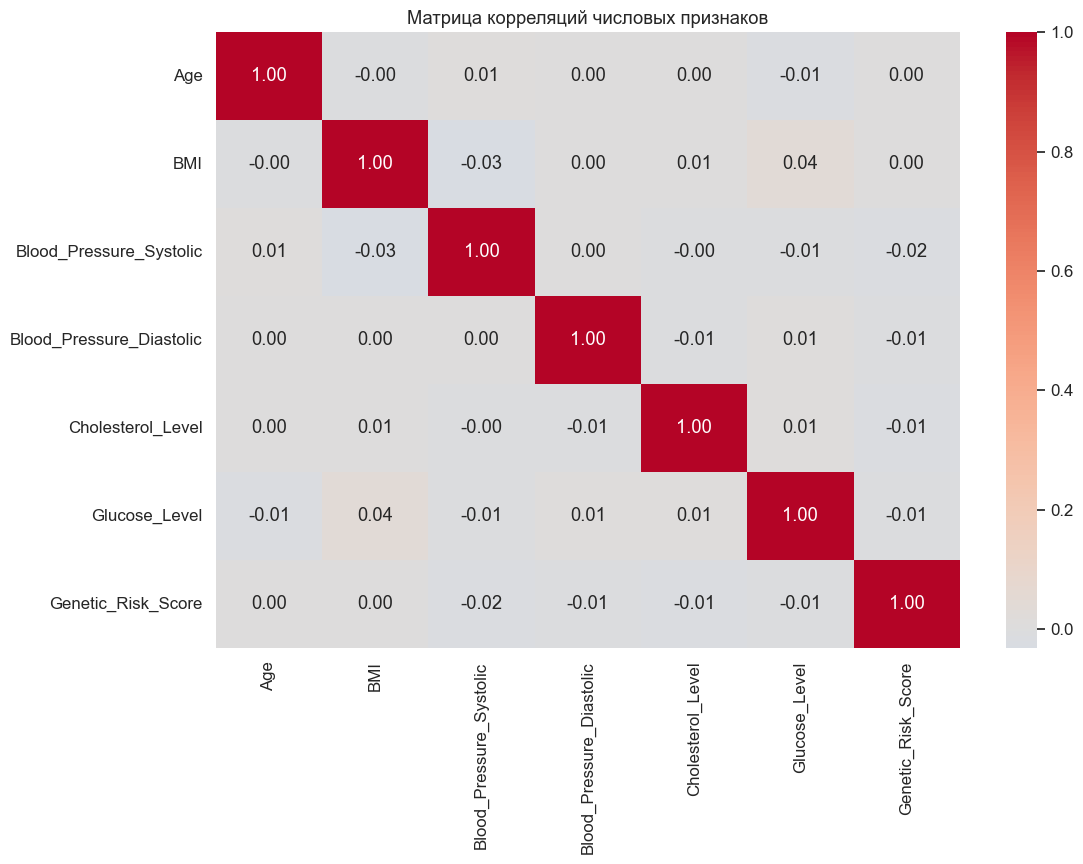

In [19]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.show()

### 9.2. Взаимосвязи категориальных переменных с целевой

In [20]:
for col in categorical_cols:
    if col != 'Disease_Risk':
        print(f"\nВзаимосвязь {col} с Disease_Risk:")
        display(pd.crosstab(df[col], df['Disease_Risk'], normalize='index') * 100)


Взаимосвязь Gender с Disease_Risk:


Disease_Risk,No,Yes
Gender,,
Female,85.504971,14.495029
Male,85.368367,14.631633
Other,86.486486,13.513514



Взаимосвязь Smoking_Status с Disease_Risk:


Disease_Risk,No,Yes
Smoking_Status,,
Current,59.697733,40.302267
Former,91.457286,8.542714
Never,92.097416,7.902584



Взаимосвязь Physical_Activity_Level с Disease_Risk:


Disease_Risk,No,Yes
Physical_Activity_Level,,
High,87.699877,12.300123
Low,77.355372,22.644628
Moderate,89.529590,10.470410



Взаимосвязь Family_History с Disease_Risk:


Disease_Risk,No,Yes
Family_History,,
No,89.260897,10.739103
Yes,82.995449,17.004551


## 10. Анализ аномальных давлений

In [25]:
incorrect_pressure = df[df['Blood_Pressure_Systolic'] <= df['Blood_Pressure_Diastolic']]

print("Анализ аномальных давлений:")
print(f"Всего записей с проблемой: {len(incorrect_pressure)}")
print(f"Это {len(incorrect_pressure)/len(df)*100:.1f}% от всех данных")

equal_pressure = df[df['Blood_Pressure_Systolic'] == df['Blood_Pressure_Diastolic']]
systolic_lower = df[df['Blood_Pressure_Systolic'] < df['Blood_Pressure_Diastolic']]

print(f"\nАнализ:")
print(f"- Систолическое < Диастолического: {len(systolic_lower)} записей")
print(f"- Систолическое = Диастолическому: {len(equal_pressure)} записей")

# анализ для случаев, где систолическое МЕНЬШЕ диастолического
if len(systolic_lower) > 0:
    pressure_diff = systolic_lower['Blood_Pressure_Diastolic'] - systolic_lower['Blood_Pressure_Systolic']
    print(f"\nАнализ превышения (только где Systolic < Diastolic):")
    print(f"Среднее превышение: {pressure_diff.mean():.1f}")
    print(f"Максимальное превышение: {pressure_diff.max():.1f}")
    print(f"Минимальное превышение: {pressure_diff.min():.1f}")

# смотрим на конкретные значения (первые 10)
print("\nПримеры проблемных записей:")
pressure_examples = incorrect_pressure[['Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic']].head(10)
display(pressure_examples)

Анализ аномальных давлений:
Всего записей с проблемой: 340
Это 8.5% от всех данных

Анализ:
- Систолическое < Диастолического: 323 записей
- Систолическое = Диастолическому: 17 записей

Анализ превышения (только где Systolic < Diastolic):
Среднее превышение: 10.2
Максимальное превышение: 29.0
Минимальное превышение: 1.0

Примеры проблемных записей:


,Blood_Pressure_Systolic,Blood_Pressure_Diastolic
0,92,117
12,108,116
29,100,104
40,98,118
43,96,114
67,115,119
90,105,110
105,91,99
108,92,101
123,110,115


In [29]:
equal_pressure = df[df['Blood_Pressure_Systolic'] == df['Blood_Pressure_Diastolic']]

print(f"Найдено {len(equal_pressure)} записей с равными давлениями")

if len(equal_pressure) > 0:
    print("ПОЛНЫЙ АНАЛИЗ ПРОФИЛЯ ЭТИХ ПАЦИЕНТОВ:")
    
    print("1. Демографические показатели:")
    print(f"   - Средний возраст: {equal_pressure['Age'].mean():.1f} лет")
    print(f"   - Распределение по полу:")
    print(equal_pressure['Gender'].value_counts())
    
    print("\n2. Медицинские показатели:")
    print(f"   - Средний BMI: {equal_pressure['BMI'].mean():.1f}")
    print(f"   - Средний уровень холестерина: {equal_pressure['Cholesterol_Level'].mean():.1f}")
    print(f"   - Средний уровень глюкозы: {equal_pressure['Glucose_Level'].mean():.1f}")
    print(f"   - Средний генетический риск: {equal_pressure['Genetic_Risk_Score'].mean():.1f}")
    
    print("\n3. Факторы риска:")
    print("   - Курение:")
    print(equal_pressure['Smoking_Status'].value_counts())
    print("   - Употребление алкоголя:")
    print(equal_pressure['Alcohol_Consumption'].value_counts())
    print("   - Физическая активность:")
    print(equal_pressure['Physical_Activity_Level'].value_counts())
    
    print("\n4. Семейная история и диагнозы:")
    print("   - Семейная история:")
    print(equal_pressure['Family_History'].value_counts())
    print("   - Предыдущие диагнозы:")
    print(equal_pressure['Previous_Diagnosis'].value_counts())
    print("   - Риск заболевания:")
    print(equal_pressure['Disease_Risk'].value_counts())

else:
    print("Записей с равными давлениями не найдено!")

Найдено 17 записей с равными давлениями
ПОЛНЫЙ АНАЛИЗ ПРОФИЛЯ ЭТИХ ПАЦИЕНТОВ:
1. Демографические показатели:
   - Средний возраст: 57.9 лет
   - Распределение по полу:
Gender
Male      9
Female    8
Name: count, dtype: int64

2. Медицинские показатели:
   - Средний BMI: 28.8
   - Средний уровень холестерина: 220.0
   - Средний уровень глюкозы: 137.6
   - Средний генетический риск: 0.5

3. Факторы риска:
   - Курение:
Smoking_Status
Never      7
Former     5
Current    5
Name: count, dtype: int64
   - Употребление алкоголя:
Alcohol_Consumption
Moderate    9
High        1
Name: count, dtype: int64
   - Физическая активность:
Physical_Activity_Level
Moderate    7
Low         6
High        4
Name: count, dtype: int64

4. Семейная история и диагнозы:
   - Семейная история:
Family_History
Yes    11
No      6
Name: count, dtype: int64
   - Предыдущие диагнозы:
Previous_Diagnosis
Pre-disease    6
Diagnosed      1
Name: count, dtype: int64
   - Риск заболевания:
Disease_Risk
No     14
Yes     3

## 11. Анализ пропусков 

### 11.1. Базовый анализ пропусков 

In [47]:
print("Анализ пропусков:")
print(f"Alcohol_Consumption: {df['Alcohol_Consumption'].isnull().sum()} пропусков (40.9%)")
print(f"Previous_Diagnosis: {df['Previous_Diagnosis'].isnull().sum()} пропусков (50.7%)")

# проверяем, связаны ли пропуски между собой
missing_both = df[df['Alcohol_Consumption'].isnull() & df['Previous_Diagnosis'].isnull()]
print(f"Пропуски в ОБОИХ колонках: {len(missing_both)}")

Анализ пропусков:
Alcohol_Consumption: 1639 пропусков (40.9%)
Previous_Diagnosis: 2027 пропусков (50.7%)
Пропуски в ОБОИХ колонках: 809


### 11.2. Поиск возможных паттернов у пропусков

In [44]:
print("Анализ паттернов пропусков:")

# 1. смотрим распределение других признаков у записей с пропусками
print("1. Alcohol_Consumption пропуски - анализ других признаков:")
alcohol_missing = df[df['Alcohol_Consumption'].isnull()]
print("Распределение Smoking_Status:")
print(alcohol_missing['Smoking_Status'].value_counts(normalize=True))
print("Распределение Physical_Activity_Level:")
print(alcohol_missing['Physical_Activity_Level'].value_counts(normalize=True))

print("\n2. Previous_Diagnosis пропуски - анализ других признаков:")
diagnosis_missing = df[df['Previous_Diagnosis'].isnull()]
print("Распределение Disease_Risk:")
print(diagnosis_missing['Disease_Risk'].value_counts(normalize=True))
print("Распределение Family_History:")
print(diagnosis_missing['Family_History'].value_counts(normalize=True))

# 2. проверяем случайность пропусков для признаков Alcohol_Consumption и Previous_Diagnosis
print("\n3. Проверка случайности пропусков:")

print("Alcohol_Consumption пропуски:")
for col in ['Disease_Risk', 'Gender', 'Smoking_Status']:
    for value in df[col].unique():
        subset = df[df[col] == value]
        missing_rate = subset['Alcohol_Consumption'].isnull().mean() * 100
        print(f"  - {col}={value}: {missing_rate:.1f}% пропусков")

print("\nPrevious_Diagnosis пропуски:")
for col in ['Disease_Risk', 'Family_History', 'Gender']:
    for value in df[col].unique():
        subset = df[df[col] == value]
        missing_rate = subset['Previous_Diagnosis'].isnull().mean() * 100
        print(f"  - {col}={value}: {missing_rate:.1f}% пропусков")

Анализ паттернов пропусков:
1. Alcohol_Consumption пропуски - анализ других признаков:
Распределение Smoking_Status:
Smoking_Status
Never      0.506406
Former     0.294082
Current    0.199512
Name: proportion, dtype: float64
Распределение Physical_Activity_Level:
Physical_Activity_Level
Moderate    0.495424
Low         0.304454
High        0.200122
Name: proportion, dtype: float64

2. Previous_Diagnosis пропуски - анализ других признаков:
Распределение Disease_Risk:
Disease_Risk
No     0.849531
Yes    0.150469
Name: proportion, dtype: float64
Распределение Family_History:
Family_History
Yes    0.606808
No     0.393192
Name: proportion, dtype: float64

3. Проверка случайности пропусков:
Alcohol_Consumption пропуски:
  - Disease_Risk=No: 41.9% пропусков
  - Disease_Risk=Yes: 35.5% пропусков
  - Gender=Female: 40.8% пропусков
  - Gender=Male: 40.7% пропусков
  - Gender=Other: 47.3% пропусков
  - Smoking_Status=Never: 41.3% пропусков
  - Smoking_Status=Former: 40.4% пропусков
  - Smoking_S

## Вывод 
### Сильные стороны DataSet:

- Все 4000 Patient_ID уникальны, дубликатов строк нет 
- Полнота данных: 13 из 15 признаков заполнены на 100%
- Крайне мало выбросов
- Данные однородные

### Проблемы DataSet:
- Пропуски в колонках Alcohol_Consumption и Previous_Diagnosis
- Выбросы в значениях BMI и Genetic_Risk_Score
- Аномальное соотношение давлений (систолическое меньше диастолического)
- Сильный дисбаланс классов в целевой переменной "Disease_Risk"

### Рекомендации для ETL
1. Для экономии памяти необходимо провести приведение типов с сохранением данных в формате .parquet. ("Gender", "Smoking_Status", "Alcohol_Consumption", "Physical_Activity_Level" и "Previous_Diagnosis" следует преобразовать в категориальный тип данных (так как есть только 3 уникальных значения), а "Family_History" и "Disease_Risk" нужно преобразовать в булевый тип данных (так как есть только 2 уникальных значения "YES" и "NO"))

2. Для устранения аномального соотношения давлений в 340 случаев рекомендовано поменять значения местами в 323 случав. У человека в норме систолическое давление всегда больше диастолического. В данных у 340 человек наоборот. При этом все цифры нормальные (90-120). У человека может быть диастолическое давление выше, но это наблюдается при серьезных патологиях сердечно-сосудистой системы. Исходя из данных нельзя сделать вывод, что пациенты имеют серьезные кардиологические нарушения. Больше похоже на ошибку переноса данных (информацию о систолическом давлении записали в колонку диастолического и наоборот). В остальных случаях (17 записей), когда давления равны, пациенты имеют реальные медицинские проблемы (высокий холестерин, глюкоза, BMI), наследственную предрасположенность, но при этом низкий диагностированный риск заболевания. Рекомендуется пометить эти данные как требующие проверки.

3. Для обработки пропусков в данных рекомендуется заполнить их отдельной категорией "Unknown". Пропуски в признаках "Alcohol_Consumption" (40.9%) и "Previous_Diagnosis" (50.7%) являются полностью случайными и равномерно распределены между всеми группами пациентов. Это указывает на отсутствие систематической причины пропусков, что позволяет использовать простое заполнение без риска внесения смещения в данные.

4. Для обеспечения качества данных рекомендуется удалить записи с нереалистичными значениями индекса массы тела ("BMI"). Обнаружено 25 случаев с "BMI" менее 15, что соответствует весу 24-27 кг для взрослого человека. Такие значения несовместимы с жизнью при нормальных показателях других клинических параметров (давление, холестерин, глюкоза), что указывает на ошибки ввода данных, а не реальные медицинские случаи.

5. Для обработки выбросов в признаке "Genetic_Risk_Score" рекомендуется сохранить все данные без удаления. Все случаи заболевания, кроме одного, встречаются в группе высокого генетического риска, что подтверждает важность этого признака для прогнозирования. Единственный случай болезни в группе низкого риска может быть объясняенен другими факторами (например высокое давление).

6. Для работы с целевой переменной "Disease_Risk" необходимо учитывать значительный дисбаланс классов. Распределение составляет 85.5% пациентов без риска заболевания против 14.5% с риском заболевания. Рекомендуется применять методы балансировки данных.